In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')

In [2]:
#read csv
df = pd.read_csv('Small_DS_preprocessed.csv')

In [3]:
#remove the first column
df.head()

,runtime,imdb,votes,budgets,genre_encoded,companies_experience,directors_experience,stars_experience,writers_experience,day,month,year,weekDay,rating_encoded,origins_encoded
0,150,8.3,73855,250000000.0,2,29,4,11,6,5,5,2023,4,3,2
1,96,7.0,39889,12000000.0,164,29,1,1,1,21,4,2023,4,4,2
2,134,7.4,79732,150000000.0,2,73,2,5,2,31,3,2023,4,3,3
3,92,7.3,93663,100000000.0,46,88,1,11,2,5,4,2023,2,2,2
4,122,6.7,66427,35000000.0,167,73,3,6,7,10,3,2023,4,4,2


**Split data**

In [4]:
#Split data with holdout method
X = df.drop(['imdb'], axis=1)
y = df['imdb']
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Split test data into test and validation sets
X_hold, X_val, y_hold, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_hold.shape, X_val.shape)
print(y_train.shape, y_hold.shape, y_val.shape)


(595, 14) (128, 14) (128, 14)
(595,) (128,) (128,)


# 2. Featrure Transformation

In [41]:
def draw_boxplots(df, columns):
    #draw boxplots vertically for each column in same figure horizontally
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for i, col in enumerate(columns):
        sns.boxplot(x=col, data=df, ax=axes[i])
    plt.show()
def draw_hist(df, columns):
    #draw histograms vertically for each column in same figure horizontally
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for i, col in enumerate(columns):
        sns.histplot(x=col, data=df, ax=axes[i], kde=True)
    plt.show()

In [5]:
def handle_outlier(X, Xtrain, type, feat):
    upper = 0
    lower = 0
    if type == 'skew':
        IQR=Xtrain[feat].quantile(0.75)-Xtrain[feat].quantile(0.25)
        lower=Xtrain[feat].quantile(0.25)-(IQR*3)
        upper=Xtrain[feat].quantile(0.75)+(IQR*3)
    else:
        upper=Xtrain[feat].mean() + 3* Xtrain[feat].std()
        lower=Xtrain[feat].mean() - 3* Xtrain[feat].std()
    X.loc[X[feat] >= upper, feat] = upper
    X.loc[X[feat] <= lower, feat] = lower
    return X

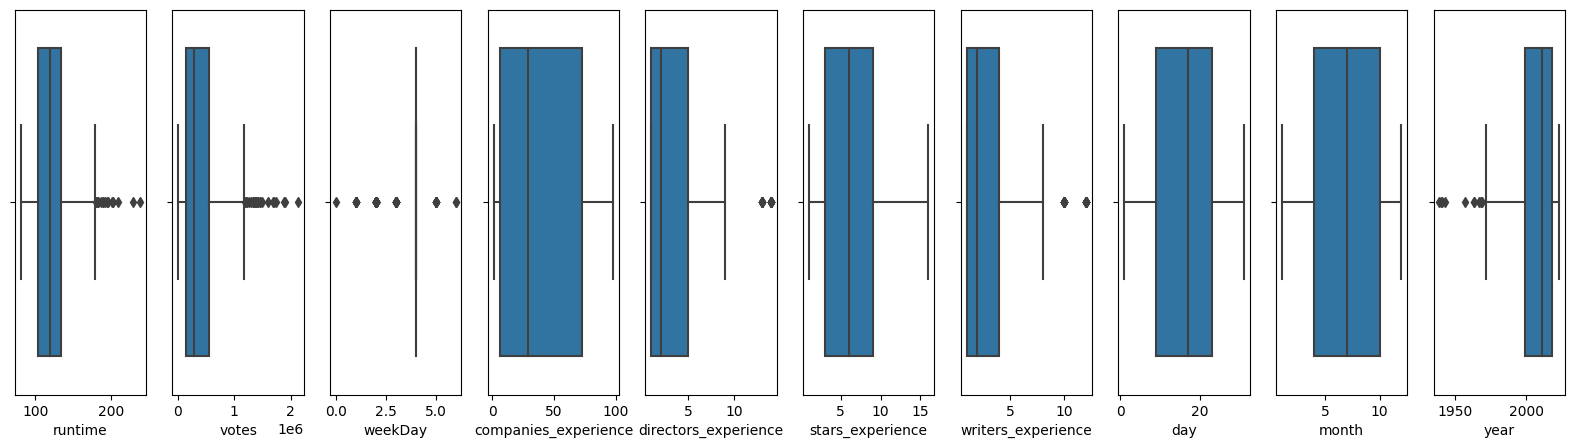

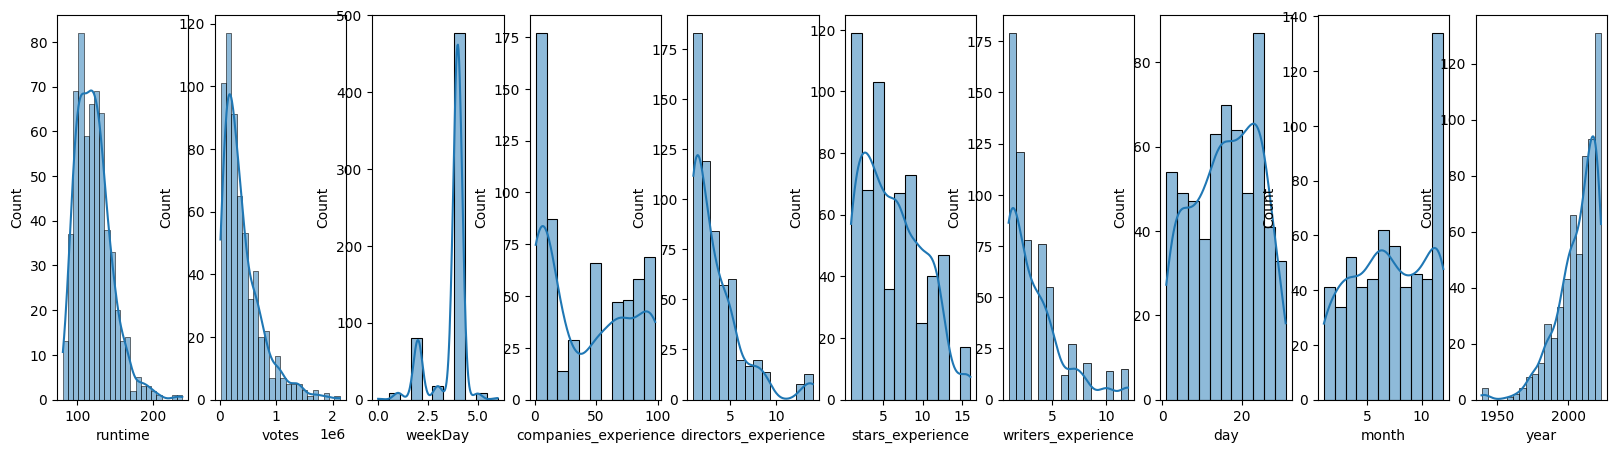

In [43]:
draw_boxplots(X_train, ['runtime','votes', 'weekDay', 'companies_experience','directors_experience','stars_experience','writers_experience','day','month', 'year'])
draw_hist(X_train, ['runtime', 'votes', 'weekDay', 'companies_experience','directors_experience','stars_experience','writers_experience','day','month', 'year'])

**1. Handle Outliers**

In [6]:
X_train = handle_outlier(X_train,X_train,"gauss","runtime")
X_train = handle_outlier(X_train,X_train,"skew","votes")

X_val = handle_outlier(X_val,X_train,"gauss","runtime")
X_val = handle_outlier(X_val,X_train,"skew","votes")

X_hold = handle_outlier(X_hold,X_train,"gauss","runtime")
X_hold = handle_outlier(X_hold,X_train,"skew","votes")

**2. Scaler**

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_hold = scaler.transform(X_hold)


# Model Training

In [9]:
def calc_score(y_val, y_pred, model_name):
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)

    print(f'MAE - RMSE - R2 of {model_name}: ', round(mae,2), round(rmse,2), round(r2,2))
    return (mae, rmse, r2)

In [11]:
def scatter(y_pred_rf, y_pred_svm, y_val):
    plt.figure(figsize=(7, 7))
    plt.title('Biểu đồ phân tán giữa giá trị IMDB dự đoán và thực tế')
    plt.scatter(y_pred_rf, y_val, label='Random Forest Regressor', color='#ffa74a', alpha=0.5, s=100)
    plt.scatter(y_pred_svm, y_val, label='Support Vector Regressor', color='#9199c9', alpha=0.5, s=100)
    plt.axline((3, 3), slope=1, color='red', label='Perfect Fit')
    plt.xlabel('IMDB dự đoán')
    plt.ylabel('IMDB thực tế')
    plt.legend()
    plt.show()

In [10]:
rf_model = RandomForestRegressor()
svm_model = SVR(kernel="linear")

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Đánh giá model
(mae_rf_1, rmse_rf_1, r2_rf_1) = calc_score(
    y_val, y_pred_rf, 'Random Forest')
(mae_svm_1, rmse_svm_1, r2_svm_1) = calc_score(y_val, y_pred_svm, 'SVM')


MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


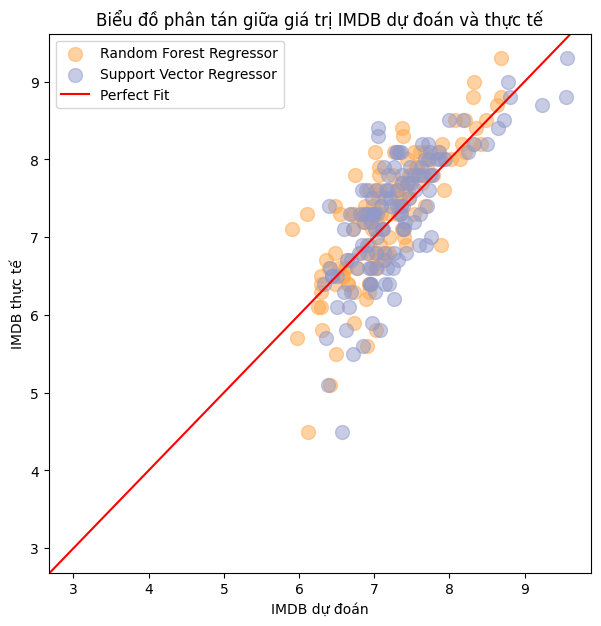

In [12]:
scatter(y_pred_rf, y_pred_svm, y_val)

# Feature Selection
Lấy ra best feat mỗi lần lặp -> fit lại model -> tính lại score -> lặp lại 

In [13]:
selected_features_rf = []
print('Selected features with random forest estimator: ')
for i in range(10,14):
    selector_rf = RFE(estimator=rf_model, n_features_to_select=i, step=1).fit(X_train, y_train)

    print(df.drop('imdb', axis=1).columns[selector_rf.support_].tolist())
    selected_features_rf.append(df.drop('imdb', axis=1).columns[selector_rf.support_].tolist())

Selected features with random forest estimator: 
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'rating_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'rating_encoded', 'origins_encoded']


In [14]:
selected_features_svm = []
print('Selected features with SVM estimator: ')
for i in range(10,14):
    selector_svm = RFE(estimator=svm_model, n_features_to_select=i, step=1).fit(X_train, y_train)

    print(df.drop('imdb', axis=1).columns[selector_svm.support_].tolist())
    selected_features_svm.append(df.drop('imdb', axis=1).columns[selector_svm.support_].tolist())


Selected features with SVM estimator: 
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'month', 'year', 'weekDay', 'rating_encoded', 'origins_encoded']


In [15]:
best_features_rf = []
min_mae = 1
#cast to dataframe
X_train = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)
X_val = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)
for i in range(0,4):
    rf_model.fit(X_train[selected_features_rf[i]], y_train)
    svm_model.fit(X_train[selected_features_rf[i]], y_train)

    y_pred_rf = rf_model.predict(X_val[selected_features_rf[i]])
    y_pred_svm = svm_model.predict(X_val[selected_features_rf[i]])

    (mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf, 'Random Forest')

    (mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm, 'SVM')

    if mae_rf < min_mae:
        min_mae = mae_rf
        best_features_rf = selected_features_rf[i]

    if mae_svm < min_mae:
        min_mae = mae_svm
        best_features_rf = selected_features_rf[i]

MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.39 0.52 0.6
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [16]:
best_features_svm = []
min_mae = 1
#cast to dataframe
X_train = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)
X_val = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)
for i in range(0,4):
    rf_model.fit(X_train[selected_features_svm[i]], y_train)
    svm_model.fit(X_train[selected_features_svm[i]], y_train)

    y_pred_rf = rf_model.predict(X_val[selected_features_svm[i]])
    y_pred_svm = svm_model.predict(X_val[selected_features_svm[i]])

    (mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf, 'Random Forest')

    (mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm, 'SVM')

    if mae_rf < min_mae:
        min_mae = mae_rf
        best_features_svm = selected_features_svm[i]

    if mae_svm < min_mae:
        min_mae = mae_svm
        best_features_svm = selected_features_svm[i]

MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.38 0.49 0.64
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.38 0.51 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [17]:
print(len(best_features_svm), ' ', best_features_svm )
print(len(best_features_rf), ' ', best_features_rf)

11   ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
13   ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'rating_encoded', 'origins_encoded']


In [18]:
rf_model.fit(X_train[best_features_svm], y_train)
svm_model.fit(X_train[best_features_svm], y_train)

y_pred_rf_svmfeat = rf_model.predict(X_val[best_features_svm])
y_pred_svm_svmfeat = svm_model.predict(X_val[best_features_svm])

(mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf_svmfeat, 'Random Forest')

(mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm_svmfeat, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.37 0.49 0.64
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [19]:
rf_model.fit(X_train[best_features_rf], y_train)
svm_model.fit(X_train[best_features_rf], y_train)

y_pred_rf_rffeat = rf_model.predict(X_val[best_features_rf])
y_pred_svm_rffeat = svm_model.predict(X_val[best_features_rf])

(mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf_rffeat, 'Random Forest')

(mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm_rffeat, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [20]:
print('Feature selected:\n ', len(best_features_svm), best_features_svm)

(mae_rf_2, rmse_rf_2, r2_rf_2) = calc_score(y_val, y_pred_rf_svmfeat, 'Random Forest')
(mae_svm_2, rmse_svm_2, r2_svm_2) = calc_score(y_val, y_pred_svm_svmfeat, 'SVM')

Feature selected:
  11 ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
MAE - RMSE - R2 of Random Forest:  0.37 0.49 0.64
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


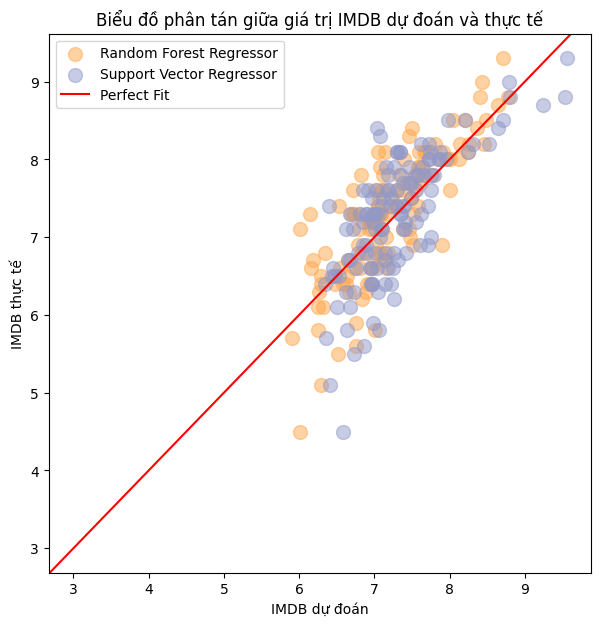

In [21]:
scatter(y_pred_rf_svmfeat, y_pred_svm_svmfeat, y_val)

**Optimize hyperparameters**

1. Random Forest Regressor

In [60]:
# Define the parameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 700, 800, 900],  # Số lượng cây trong rừng
    'max_depth': [None, 5, 10],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để chia một nút trong cây
    'min_samples_leaf': [1, 2, 4],  # Số lượng mẫu tối thiểu trong mỗi lá của cây
    'max_features': ['auto', 'sqrt'],  # Số lượng đặc trưng được xem xét khi tìm kiếm phân chia tốt nhất
    'random_state': [42]  # Giá trị random_state để đảm bảo kết quả tái tạo được như nhau
}
# Create a grid search object
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
#cast X_val to dataframe with best features
X_val_tmp = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
X_train_tmp = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
# Fit the grid search object to the data
grid_search_rf.fit(X_train_tmp, y_train)
# Print the best parameters and score
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 42}
Best score: -0.40283911945853956


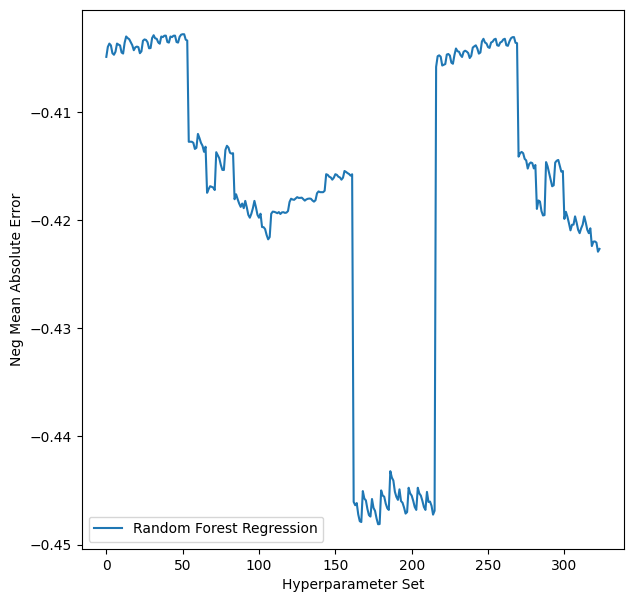

In [64]:
#plot loss function
plt.figure(figsize=(7, 7))
plt.plot(grid_search_rf.cv_results_['mean_test_score'], label='Random Forest Regression')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Neg Mean Absolute Error')
plt.legend()

2. Support Vector Regressor

In [62]:
# define the range of hyperparameters
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10]
}

# create a grid search object
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring='neg_mean_absolute_error')

X_val_tmp = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
X_train_tmp = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)[best_features_svm]

# fit the grid search to the data
grid_search_svm.fit(X_train_tmp, y_train)

# print the best hyperparameters and the corresponding mean squared error
print(grid_search_svm.best_params_)
print(-grid_search_svm.best_score_)


{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}
0.40643940276462853


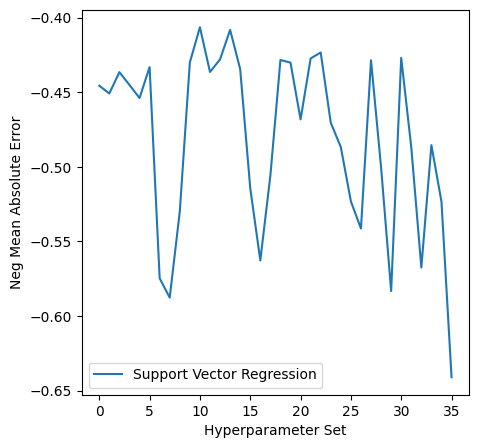

In [65]:
#plot loss function
plt.figure(figsize=(5, 5))
filtered_neg_mae = [score for score in grid_search_svm.cv_results_['mean_test_score'] if score > -1]
plt.plot(filtered_neg_mae, label='Support Vector Regression')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Neg Mean Absolute Error')
plt.legend()

Retrain model with best hyperparameters

In [22]:
# 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 42
# 'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'
rf_model = RandomForestRegressor(max_depth = None, max_features = 'auto', min_samples_leaf = 4, min_samples_split = 10, n_estimators = 600, random_state = 42)
svm_model = SVR(C= 1, epsilon= 0.1, kernel= 'rbf')

rf_model.fit(X_train[best_features_svm], y_train)
svm_model.fit(X_train[best_features_svm], y_train)

y_pred_rf = rf_model.predict(X_val[best_features_svm])
y_pred_svm = svm_model.predict(X_val[best_features_svm])

(mae_rf_3, rmse_rf_3, r2_rf_3) = calc_score(y_val, y_pred_rf, 'Random Forest')
(mae_svm_3, rmse_svm_3, r2_svm_3) = calc_score(y_val, y_pred_svm, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.63
MAE - RMSE - R2 of SVM:  0.4 0.51 0.61


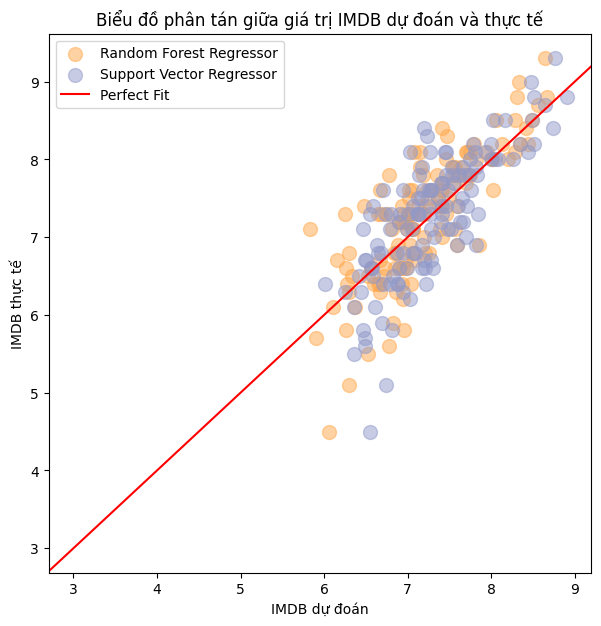

In [23]:
scatter(y_pred_rf, y_pred_svm, y_val)

In [68]:
#create dataframe with all results only mae score and show the improvement
results = pd.DataFrame({ 'Model': ['Random Forest', 'SVM', 'Random Forest', 'SVM', 'Random Forest', 'SVM'],
                        'Step': ['All Features', 'All Features', 'Selected Features', 'Selected Features', 'Tuned Hyperparams', 'Tuned Hyperparams'],
                        'MAE': [mae_rf, mae_svm, mae_rf_2, mae_svm_2, mae_rf_3, mae_svm_3],
                        'RMSE': [rmse_rf, rmse_svm, rmse_rf_2, rmse_svm_2, rmse_rf_3, rmse_svm_3],
                        'R2': [r2_rf, r2_svm, r2_rf_2, r2_svm_2, r2_rf_3, r2_svm_3],
                        'MAE Improvement': ['-', '-', 
                                        mae_rf_2-mae_rf, 
                                        mae_svm_2-mae_svm, 
                                        mae_rf_3-mae_rf_2, 
                                        mae_svm_3-mae_svm_2],
                        'RMSE Improvement': ['-', '-',
                                            rmse_rf_2-rmse_rf,
                                            rmse_svm_2-rmse_svm,
                                            rmse_rf_3-rmse_rf_2,
                                            rmse_svm_3-rmse_svm_2],
                        'R2 Improvement': ['-', '-',
                                            r2_rf_2-r2_rf,
                                            r2_svm_2-r2_svm,
                                            r2_rf_3-r2_rf_2,
                                            r2_svm_3-r2_svm_2]

                                        })
# results = results[['Model', 'Step', 'MAE', 'RMSE', 'R2']]
results

,Model,Step,MAE,RMSE,R2,MAE Improvement,RMSE Improvement,R2 Improvement
0,Random Forest,All Features,0.383914,0.507495,0.611846,-,-,-
1,SVM,All Features,0.410268,0.540593,0.559567,-,-,-
2,Random Forest,Selected Features,0.381563,0.499272,0.624324,-0.002352,-0.008224,0.012478
3,SVM,Selected Features,0.419578,0.547529,0.548192,0.00931,0.006936,-0.011375
4,Random Forest,Tuned Hyperparams,0.378951,0.493442,0.633046,-0.002612,-0.005829,0.008721
5,SVM,Tuned Hyperparams,0.379751,0.492239,0.634833,-0.039827,-0.05529,0.086641


# Testing on test set

MAE - RMSE - R2 of Random Forest:  0.39 0.53 0.6
MAE - RMSE - R2 of SVM:  0.37 0.51 0.63


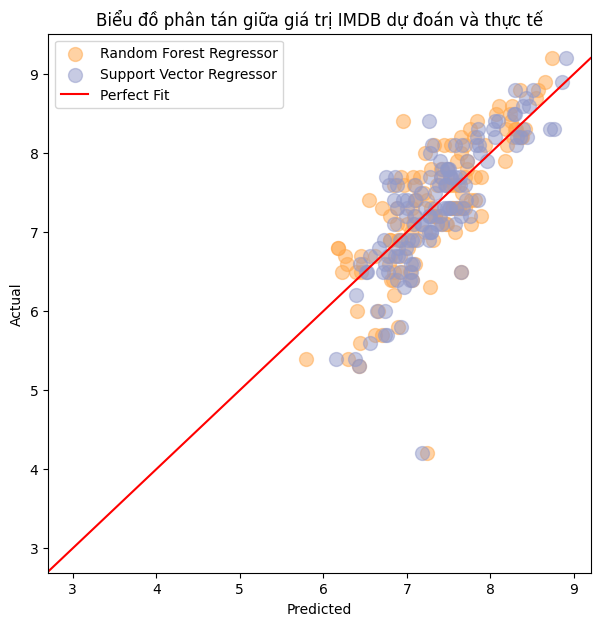

In [69]:
#test on hold set with final model
X_hold = pd.DataFrame(X_hold, columns=df.drop('imdb', axis=1).columns)

yhold_pred_rf = rf_model.predict(X_hold[best_features_svm])
yhold_pred_svm = svm_model.predict(X_hold[best_features_svm])

(mae_rf_4, rmse_rf_4, r2_rf_4) = calc_score(y_hold, yhold_pred_rf, 'Random Forest')
(mae_svm_4, rmse_svm_4, r2_svm_4) = calc_score(y_hold, yhold_pred_svm, 'SVM')

scatter(yhold_pred_rf, yhold_pred_svm, y_hold)